# Import

In [21]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import yfinance as yf
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

def d(*obj):
    for o in obj:
        display(o)

def p(*obj):
    for o in obj:
        print(o)

def _np(ls):
    return np.array(ls)

def r(f, unit=3):
    return round(f, unit)

In [22]:
import sys
sys.path.append('../../../qwok/')
from visualization import Visualization as Vis
from signal_oscillator import Price_Oscillator_Signal

# Config

In [23]:
ticker_1, ticker_2 = 'GC=F', 'BTC=F'
start, end = '2021-12-13', '2023-12-13'

# Data Collection

In [24]:
df_btc = yf.download(ticker_1, start=start, end=end)
df_btc['Return'] = df_btc['Close'].pct_change()
df_gold = yf.download(ticker_2, start=start, end=end)
df_gold['Return'] = df_gold['Close'].pct_change()
df = pd.merge(df_btc, df_gold, left_index=True, right_index=True, suffixes=('_A', '_B'))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


# Price

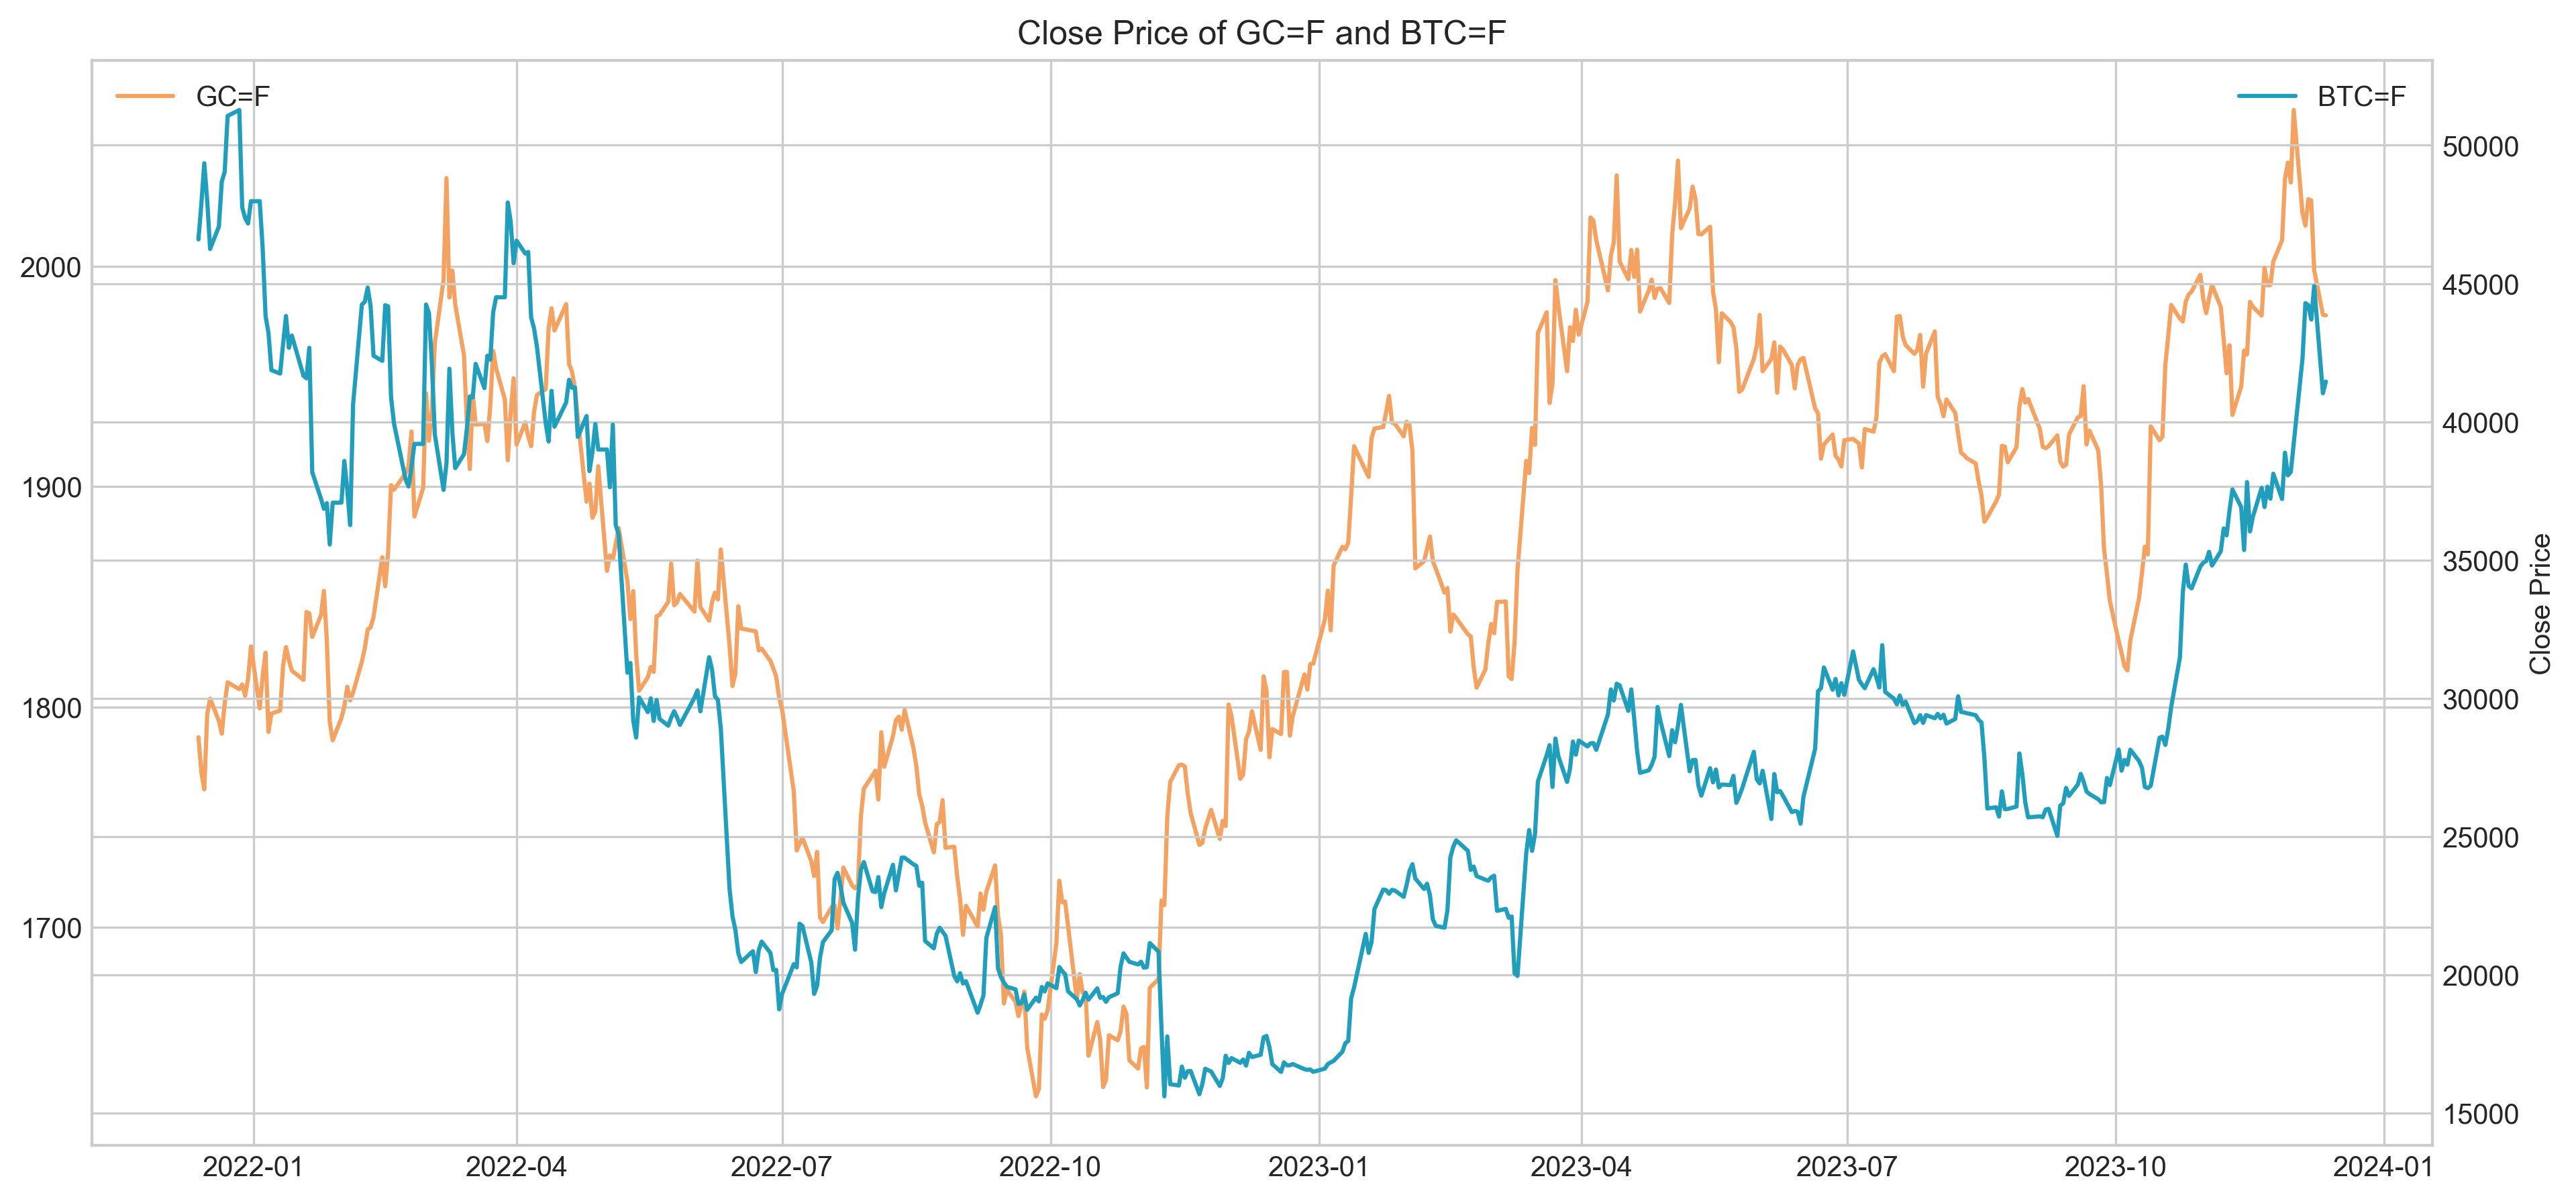

In [25]:
fig = plt.figure(figsize=(15, 7), dpi=300)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ax1.plot(df['Close_A'], c='#f4a261', label=ticker_1)
ax2.plot(df['Close_B'], c='#219ebc', label=ticker_2)

plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title(f'Close Price of {ticker_1} and {ticker_2}')

ax1.legend(loc=2)
ax2.legend(loc=1)
plt.show()

# Correlation

In [26]:
p(f'Correlation between {ticker_1} and {ticker_2}')
p(f'From {df.index[0]} to {df.index[-1]}')

r2_pearson = df['Return_A'].corr(df['Return_B'], method='pearson')
r2_spearman = df['Return_A'].corr(df['Return_B'], method='spearman')
p(r(r2_pearson))
p(r(r2_spearman))

Correlation between GC=F and BTC=F
From 2021-12-13 00:00:00 to 2023-12-12 00:00:00
0.093
0.031


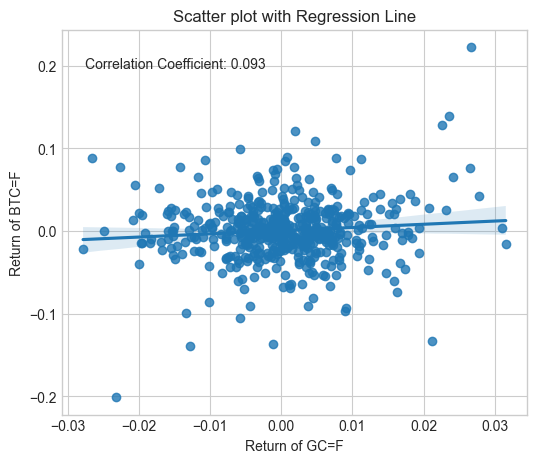

In [27]:
fig = plt.figure(figsize=(6, 5), dpi=100)

ax = fig.add_subplot(111)
sns.regplot(x=df['Return_A'], y=df['Return_B'], ax=ax, scatter=True)

ax.annotate(f'Correlation Coefficient: {r(r2_pearson)}', xy=(0.05, 0.90), xycoords='axes fraction')
ax.set_xlabel(f'Return of {ticker_1}')
ax.set_ylabel(f'Return of {ticker_2}')
ax.set_title('Scatter plot with Regression Line')

plt.show()

In [28]:
window_rolling = 60
r2_rolling = df['Return_A'].rolling(window_rolling).corr(df['Return_B'])

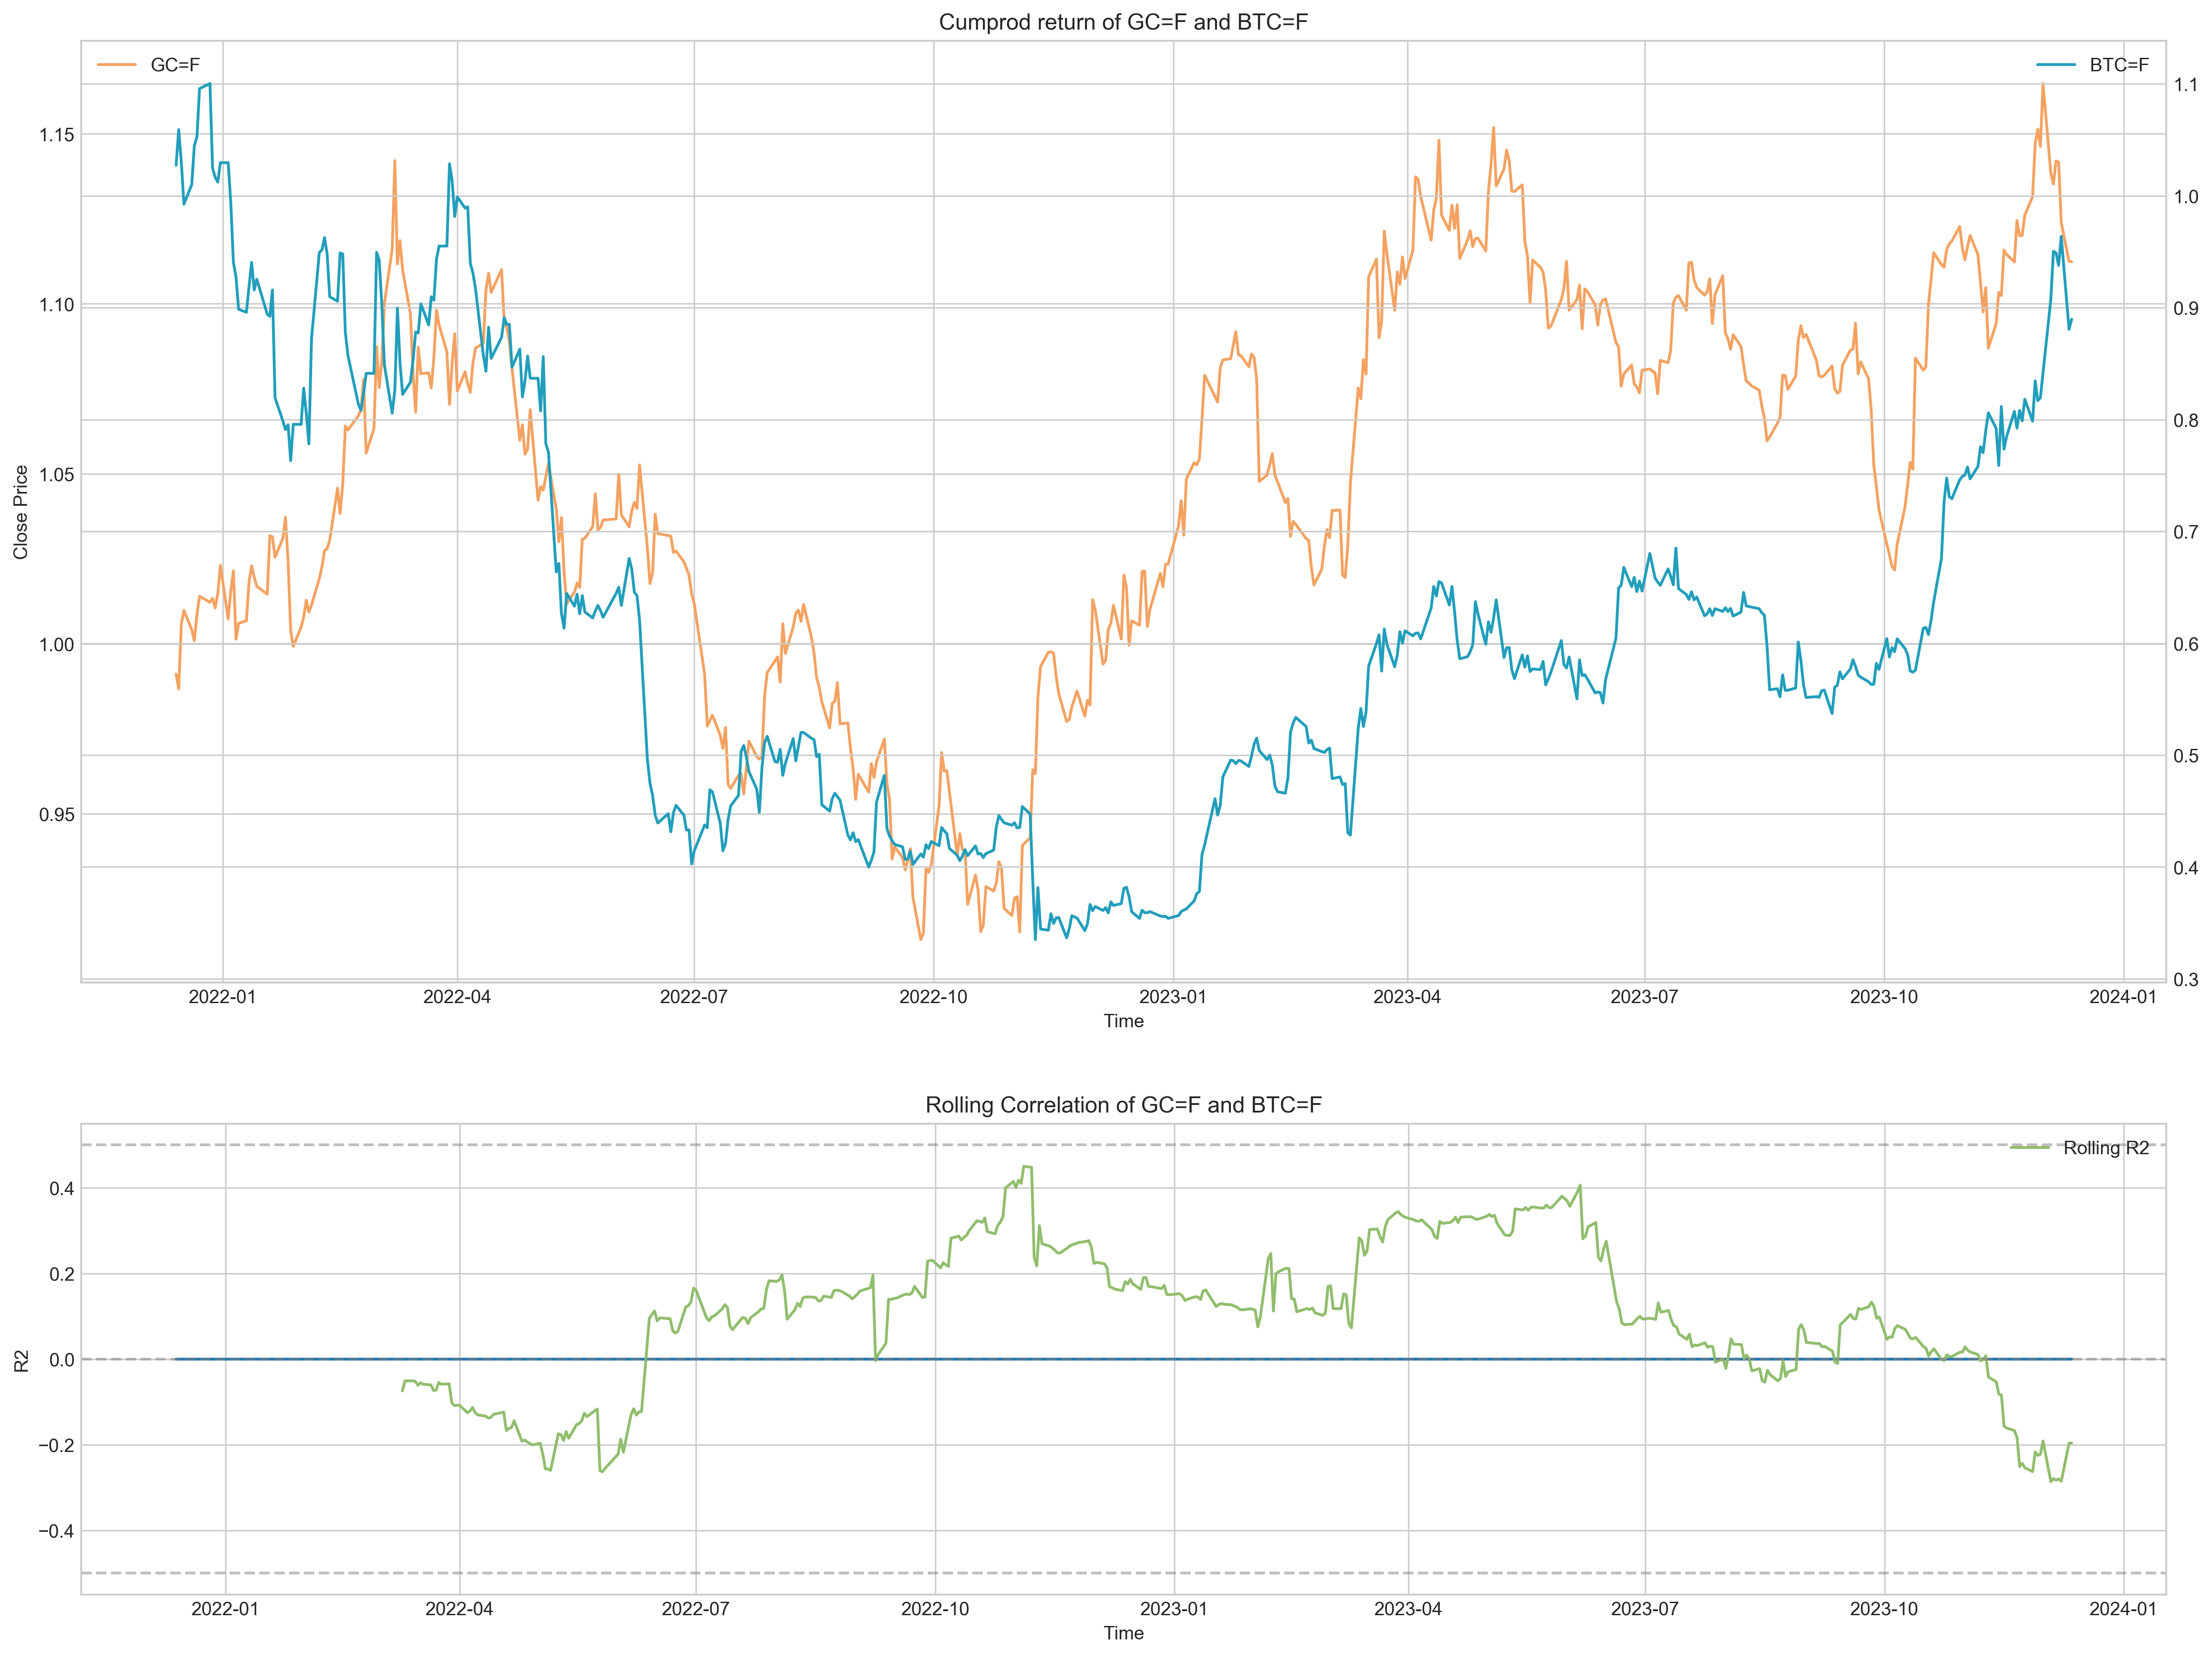

In [29]:
fig = plt.figure(figsize=(20, 15), dpi=300)
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0])
ax2 = ax1.twinx()

ax1.plot((df['Return_A']+1).cumprod(), c='#f4a261', label=ticker_1)
ax2.plot((df['Return_B']+1).cumprod(), c='#219ebc', label=ticker_2)

ax1.set_xlabel('Time')
ax1.set_ylabel('Close Price')
plt.title(f'Cumprod return of {ticker_1} and {ticker_2}')

ax1.legend(loc=2)
ax2.legend(loc=1)

# Create the second subplot for r2_rolling
ax3 = fig.add_subplot(gs[1])
ax3.plot(pd.Series(0, index=df.index))
ax3.plot(r2_rolling, c='#90be6d', label='Rolling R2')
ax3.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax3.axhline(y=-0.5, color='gray', linestyle='--', alpha=0.5)

ax3.set_title(f'Rolling Correlation of {ticker_1} and {ticker_2}')
ax3.set_xlabel('Time')
ax3.set_ylabel('R2')
ax3.legend()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.2)

plt.show()

In [30]:
p('Statistics of the rolling r2')
p(r2_rolling.describe())

Statistics of the rolling r2
count    443.000000
mean       0.101633
std        0.168156
min       -0.286572
25%        0.003170
50%        0.116833
75%        0.225441
max        0.450461
dtype: float64


# Performance

In [31]:
def get_sharpeRatio(pnl, multiplier:int = 1):
    return pnl.mean() / pnl.std() * np.sqrt(multiplier)

In [32]:
from scipy import stats
def ttest_one_sample(dist, threshold, alternative='greater'):
    """
    Perform a one-sample t-test to test if the mean of a distribution is greater than a threshold value.
    Parameters:
        dist (array_like): The sample distribution.
        threshold (float): The threshold value.
        alternative (str): The alternative hypothesis. Can be 'greater', 'less', or 'two-sided'.
    Returns:
        p_value (float): The p-value of the test.
                         Given the null hypothesis is true, the probability of the observation
    """
    t_stat, p_value = stats.ttest_1samp(dist, threshold, alternative=alternative)
    return r(p_value)

In [33]:
bt_obj_a = Vis(df['Close_A'], df['Close_A'].apply(lambda x: 1), method_pnl='cumprod')
bt_obj_b = Vis(df['Close_B'], df['Close_B'].apply(lambda x: 1), method_pnl='cumprod')
pd.DataFrame([bt_obj_a.stat, bt_obj_b.stat], index=[ticker_1, ticker_2]).T

,GC=F,BTC=F
start,2021-12-13 00:00:00,2021-12-13 00:00:00
end,2023-12-12 00:00:00,2023-12-12 00:00:00
len_timeframe,503,503
leverage,1,1
resolution(hr),24.0,24.0
count_day_tradable_yearly,252,252
long_short_ratio,inf,inf
holding_ratio,1.0,1.0
expected_return,0.00024,0.00047
annualized_return,0.05234,-0.05688


In [34]:
window_rolling = 60
sr_rolling_a = df['Return_A'].rename(f'Rolling Sharpe Ratio ({ticker_1})').rolling(window_rolling).apply(lambda x:get_sharpeRatio(x, 252))
sr_rolling_b = df['Return_B'].rename(f'Rolling Sharpe Ratio ({ticker_2})').rolling(window_rolling).apply(lambda x:get_sharpeRatio(x, 252))
sr_diff = (sr_rolling_a - sr_rolling_b).rename(f'Difference({ticker_1} - {ticker_2}')
p(f'The statistics of rolling sharpe ratio of {ticker_1} and {ticker_2}')
d(pd.concat([sr_rolling_a.describe(), sr_rolling_b.describe(), sr_diff.describe()], axis=1))

print('Null Hypothesis: the sr_diff is less than 0 (meaning the GC is underperform BTC)')
print('Alternative Hypothesis: the sr_diff is greater than 0 (meaning the GC is outperform BTC)')
p_value = ttest_one_sample(sr_diff.dropna(), 0, 'greater')
print(f'P-value: {p_value}')
ci = 95
if p_value < 1 - ci / 100:
    print(f'Reject the null hypothesis in {ci}% confident interval')
else:
    print(f'Cannot reject the null hypothesis in {ci}% confident interval')

The statistics of rolling sharpe ratio of GC=F and BTC=F


,Rolling Sharpe Ratio (GC=F),Rolling Sharpe Ratio (BTC=F),Difference(GC=F - BTC=F
count,443.000000,443.000000,443.000000
mean,0.164653,0.221514,-0.056861
std,1.862717,1.999974,1.785300
min,-4.277615,-5.119997,-4.099931
25%,-1.363917,-1.070125,-1.329230
50%,0.363040,0.085520,-0.248652
75%,1.625702,1.287337,1.215321
max,4.709516,5.313936,4.041460


Null Hypothesis: the sr_diff is less than 0 (meaning the GC is underperform BTC)
Alternative Hypothesis: the sr_diff is greater than 0 (meaning the GC is outperform BTC)
P-value: 0.749
Cannot reject the null hypothesis in 95% confident interval


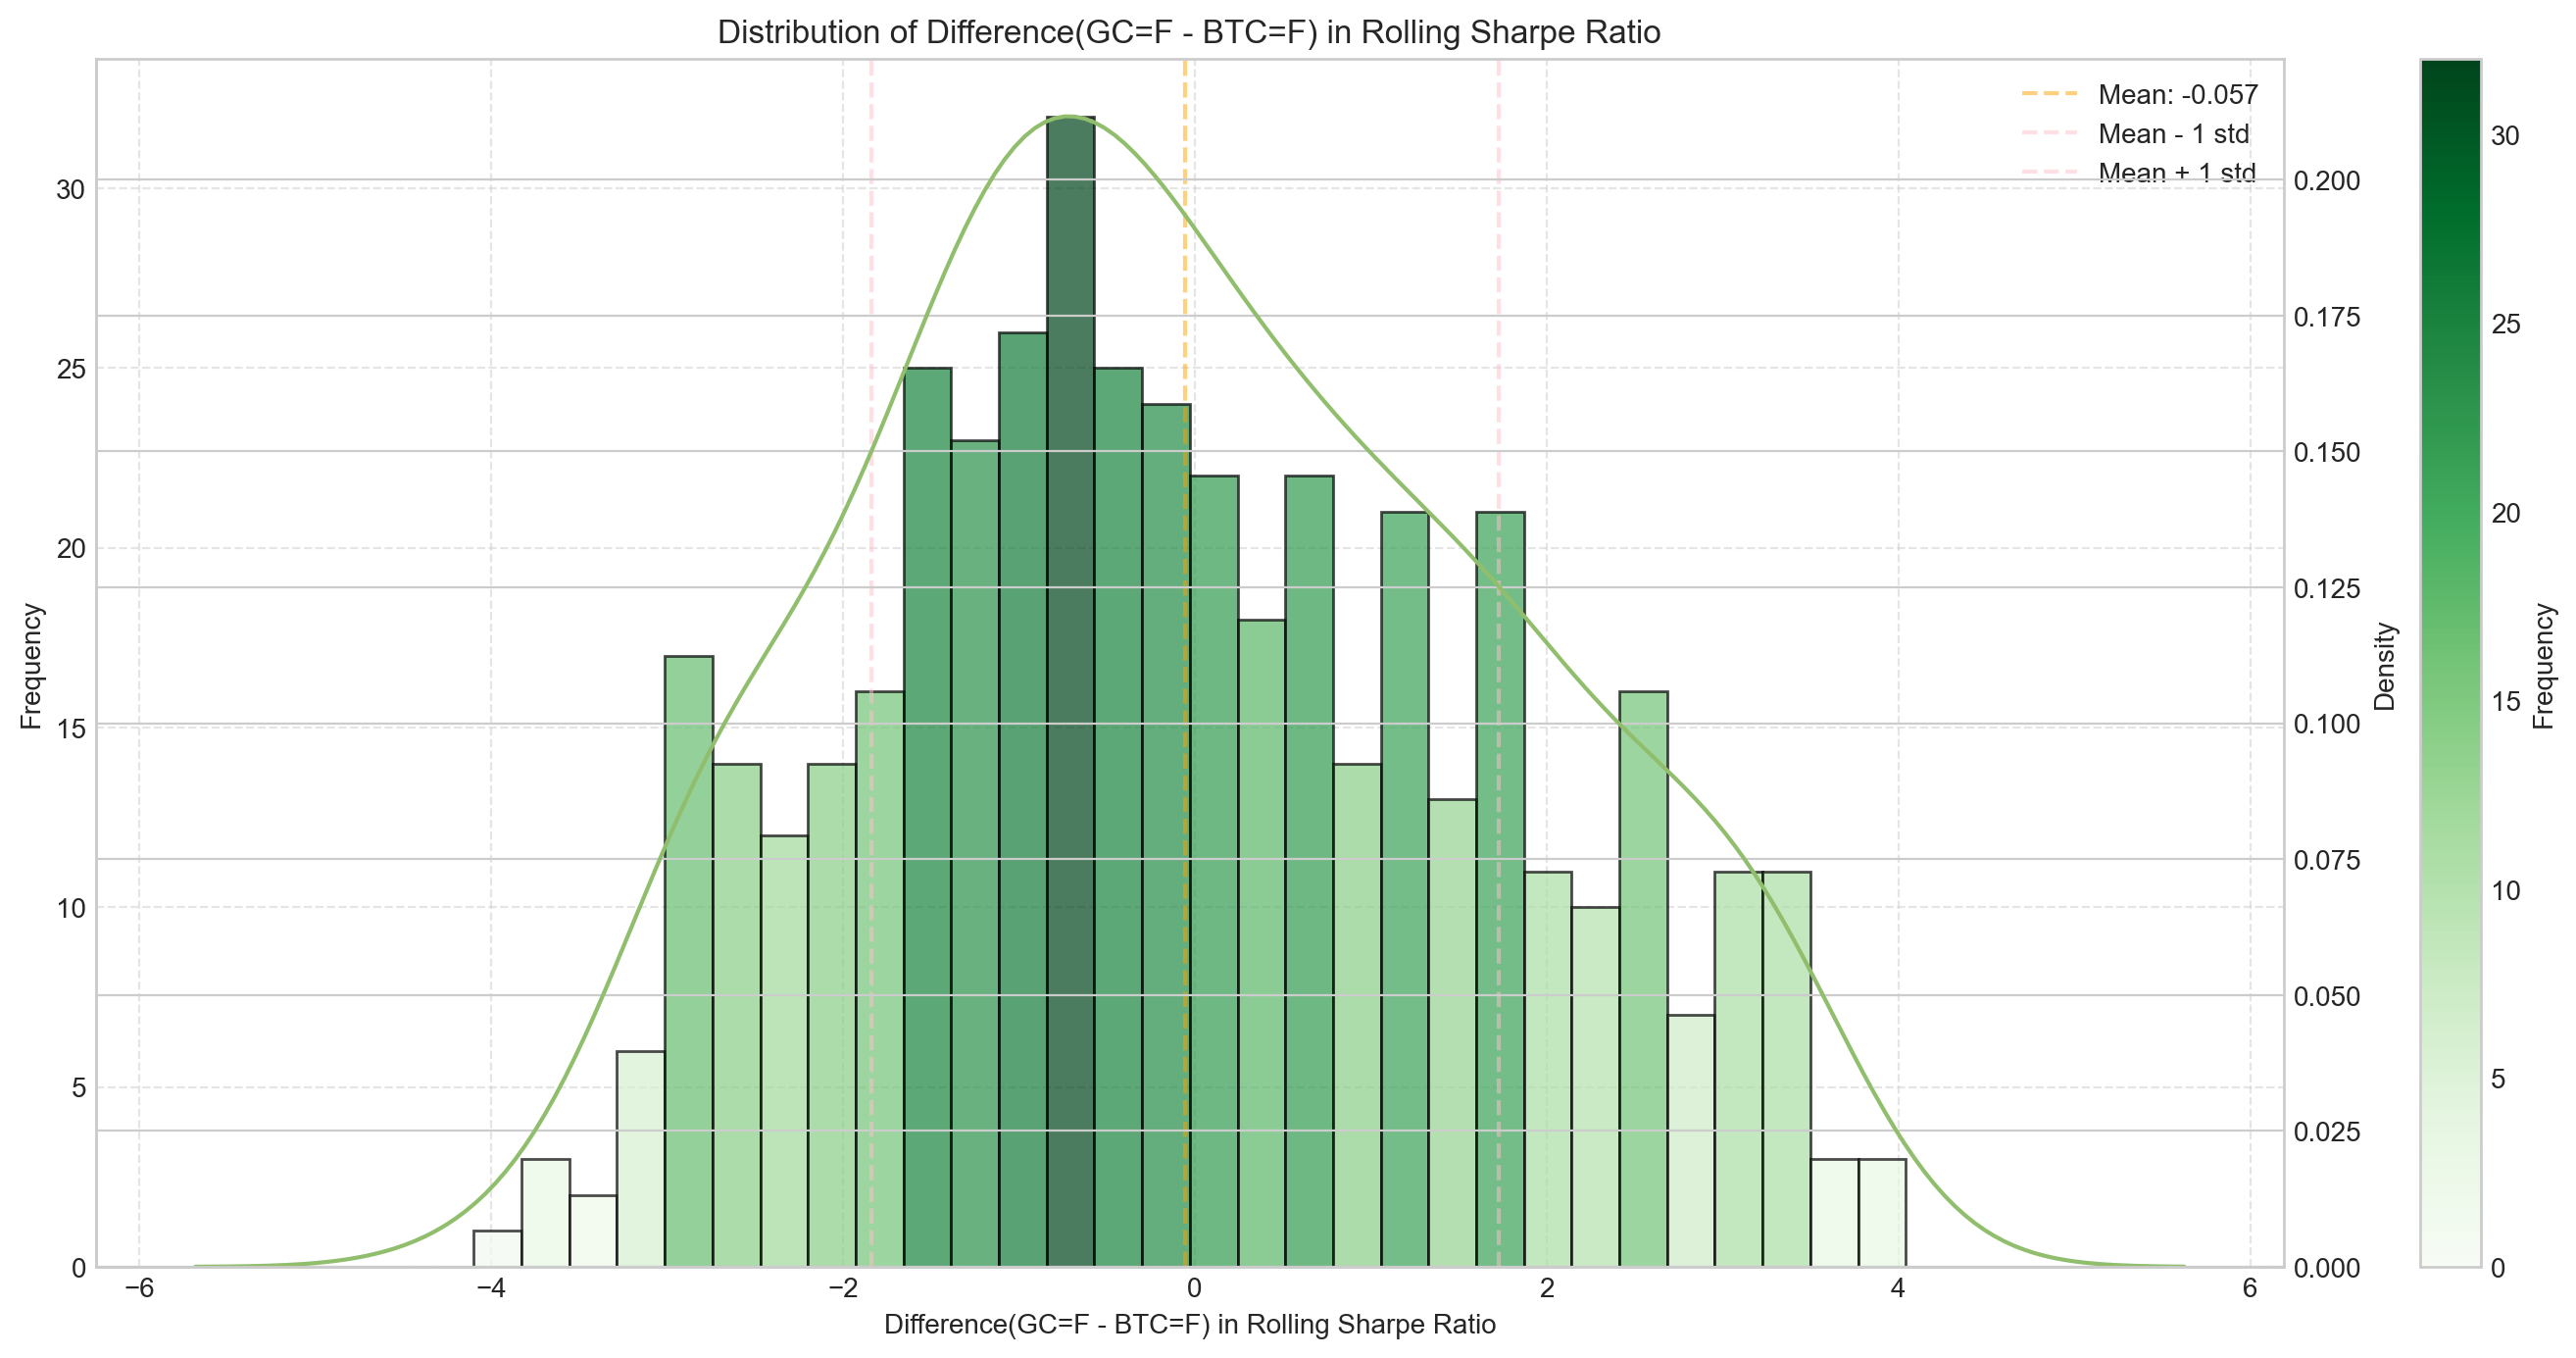

In [35]:
# Calculate mean and standard deviation
mean_diff = np.mean(sr_diff)
std_diff = np.std(sr_diff)

# Plotting the histogram and KDE plot
fig, ax1 = plt.subplots(figsize=(18, 8), dpi=200)
ax2 = ax1.twinx()  # Create a twin axis for the KDE plot

# Plot histogram with colormap
n, bins, patches = ax1.hist(sr_diff, bins=30, alpha=0.7, color='#90be6d', edgecolor='black')

# Add a colorbar
norm = plt.Normalize(0, max(n))
colors = plt.cm.Greens(norm(n))
for patch, color in zip(patches, colors):
    patch.set_facecolor(color)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='Greens', norm=norm), ax=ax1)
cbar.set_label('Frequency')

# Plot KDE plot
sns.kdeplot(sr_diff, color='#90be6d', ax=ax2)

# Set labels and title
ax1.set_xlabel(f'Difference({ticker_1} - {ticker_2}) in Rolling Sharpe Ratio')
ax1.set_ylabel('Frequency')
ax2.set_ylabel('Density')
ax1.set_title(f'Distribution of Difference({ticker_1} - {ticker_2}) in Rolling Sharpe Ratio')

# Add gridlines for the histogram
ax1.grid(True, linestyle='--', alpha=0.5)

# Add a vertical line for mean and +- 1 standard deviation
ax1.axvline(mean_diff, color='orange', linestyle='--', label=f'Mean: {r(mean_diff)}', alpha=0.5)
ax1.axvline(mean_diff - std_diff, color='pink', linestyle='--', label='Mean - 1 std', alpha=0.5)
ax1.axvline(mean_diff + std_diff, color='pink', linestyle='--', label='Mean + 1 std', alpha=0.5)

# Remove spines from the second axis
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Add a legend
ax1.legend()

# Show the plot
plt.show()

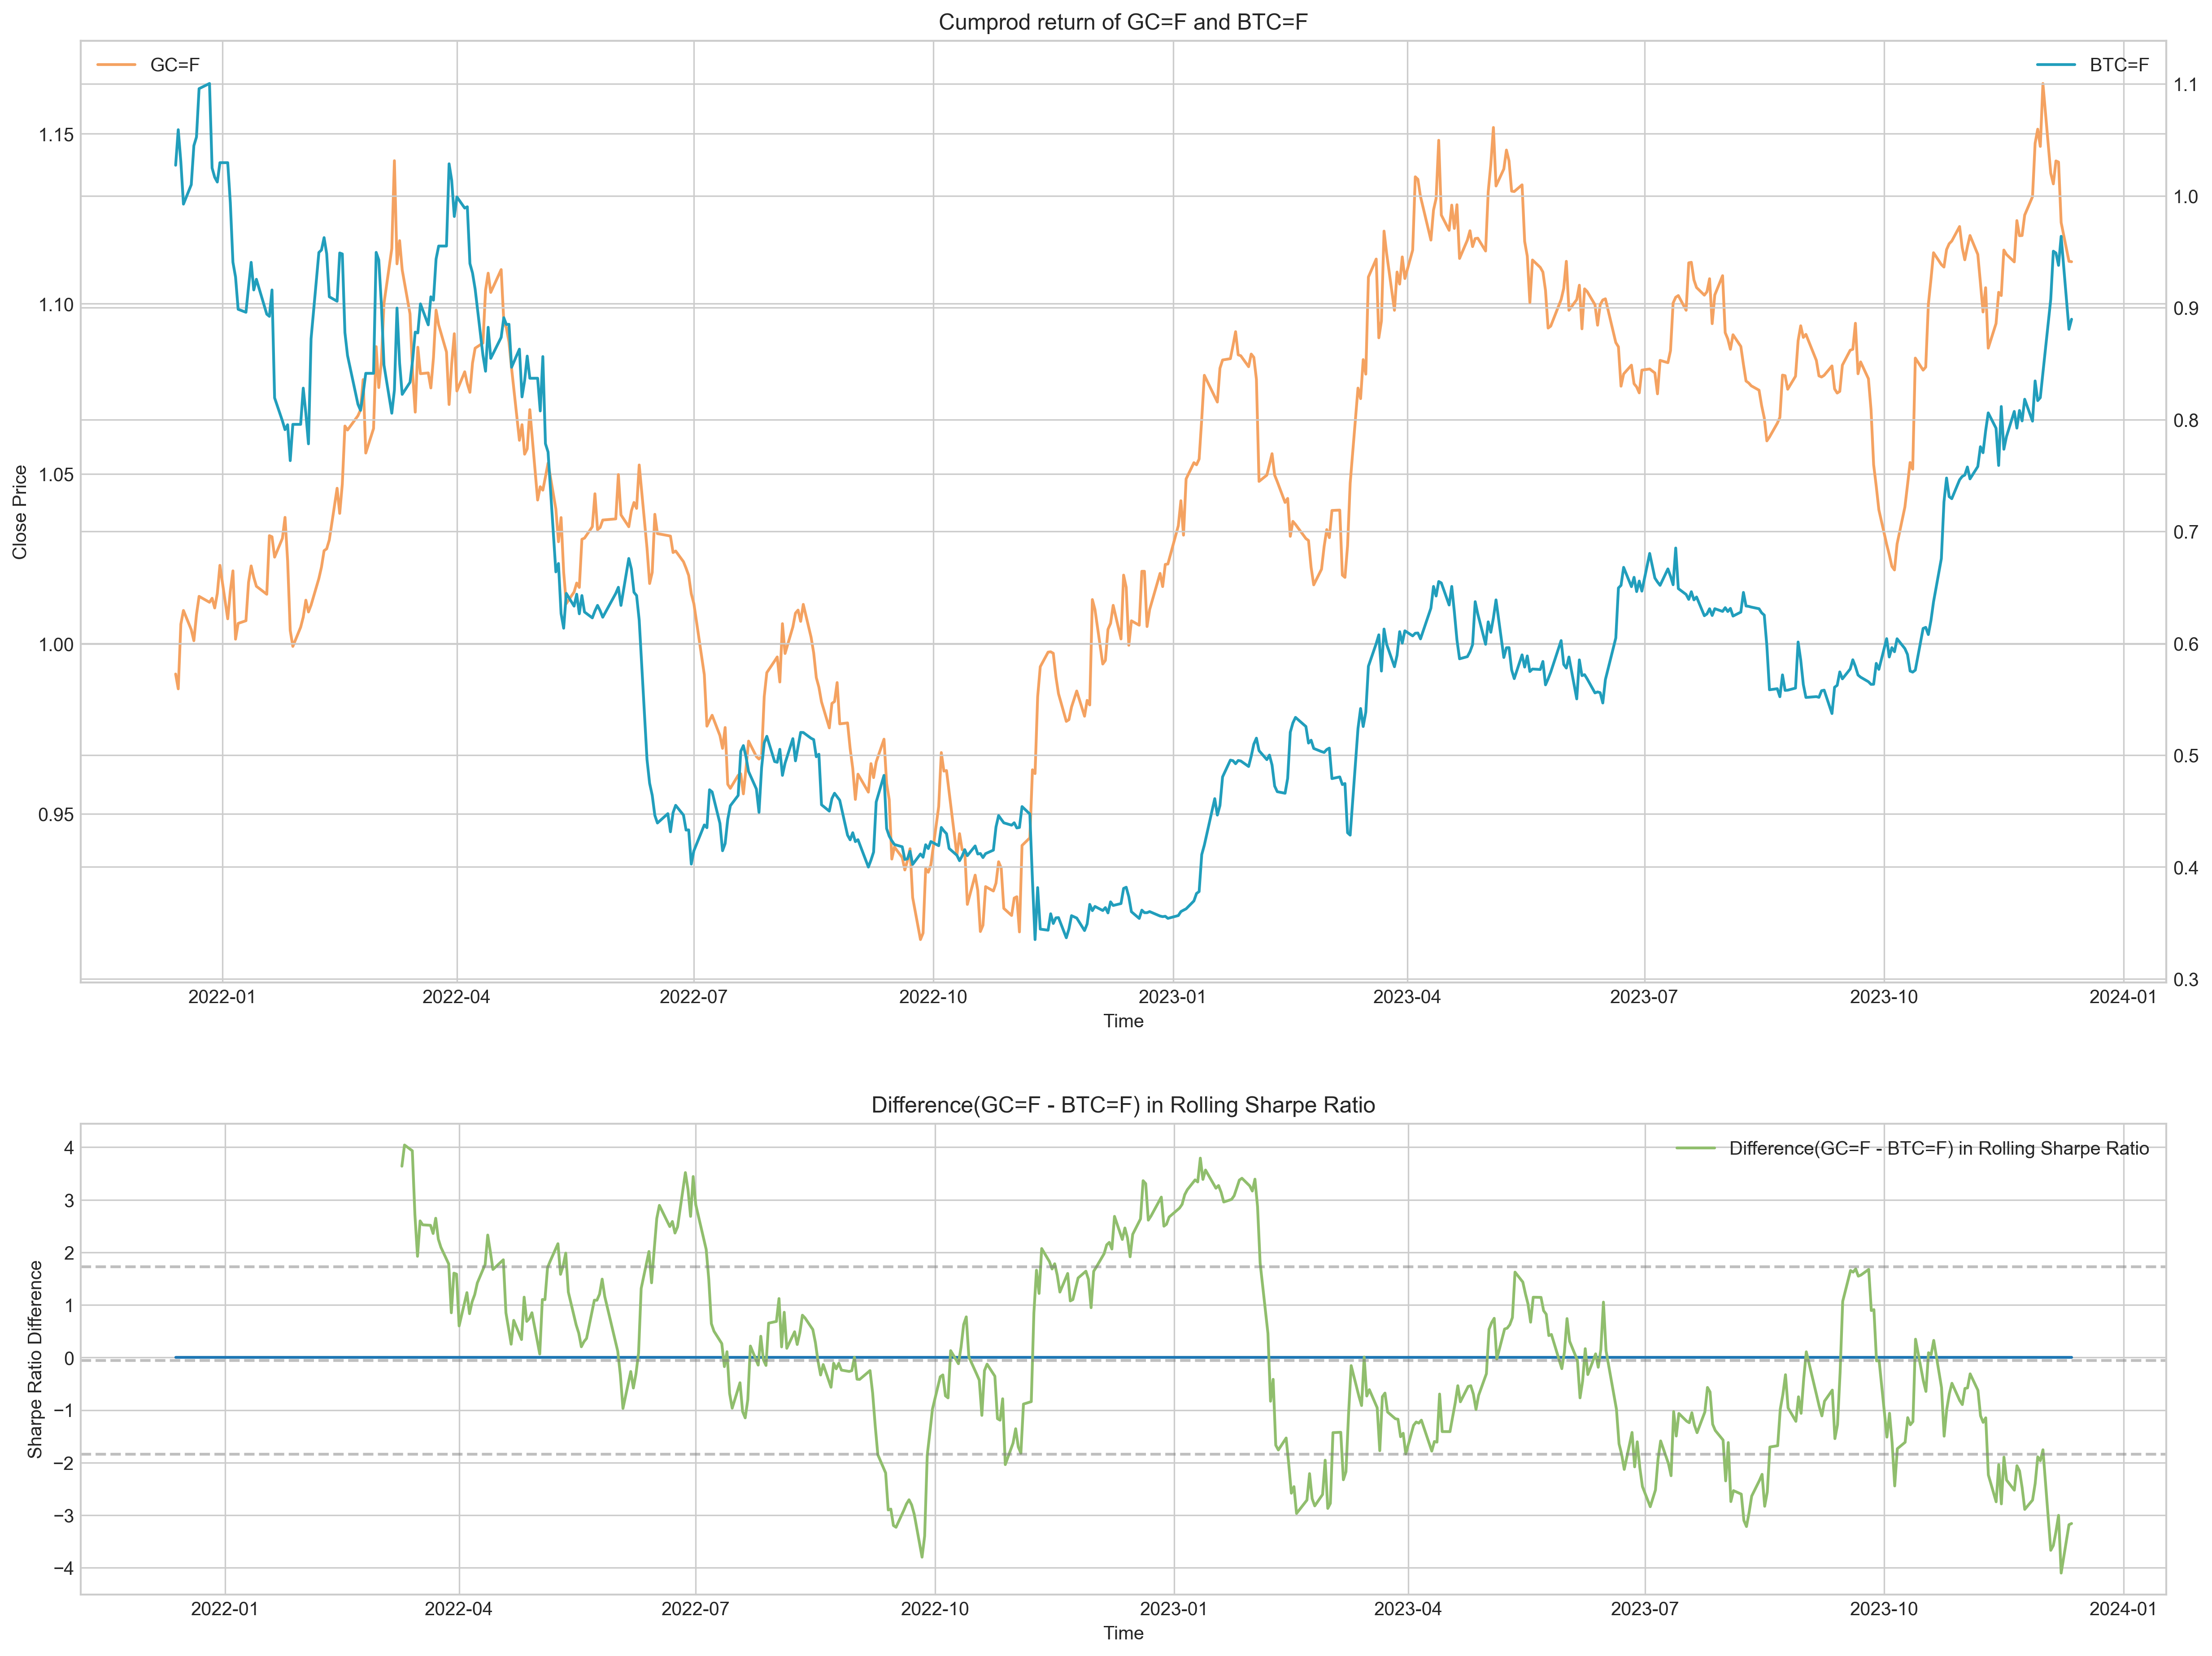

In [36]:
fig = plt.figure(figsize=(20, 15), dpi=300)
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0])
ax2 = ax1.twinx()

ax1.plot((df['Return_A']+1).cumprod(), c='#f4a261', label=ticker_1)
ax2.plot((df['Return_B']+1).cumprod(), c='#219ebc', label=ticker_2)

ax1.set_xlabel('Time')
ax1.set_ylabel('Close Price')
plt.title(f'Cumprod return of {ticker_1} and {ticker_2}')

ax1.legend(loc=2)
ax2.legend(loc=1)

# Create the second subplot for r2_rolling
ax3 = fig.add_subplot(gs[1])
ax3.plot(pd.Series(0, index=df.index))
ax3.plot(sr_diff, c='#90be6d', label=f'Difference({ticker_1} - {ticker_2}) in Rolling Sharpe Ratio')
ax3.axhline(y=mean_diff, color='gray', linestyle='--', alpha=0.5)
ax3.axhline(y=mean_diff+std_diff, color='gray', linestyle='--', alpha=0.5)
ax3.axhline(y=mean_diff-std_diff, color='gray', linestyle='--', alpha=0.5)

ax3.set_title(f'Difference({ticker_1} - {ticker_2}) in Rolling Sharpe Ratio')
ax3.set_xlabel('Time')
ax3.set_ylabel('Sharpe Ratio Difference')
ax3.legend()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.2)

plt.show()

# QC

In [37]:
df['Close_A'].pct_change().iloc[-5:].corr(df['Close_B'].pct_change().iloc[-5:])

0.1243899551637777

In [38]:
dist = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
threshold = 3
alternative = 'greater'
p_value = ttest_one_sample(dist, threshold, alternative)

print(dist.mean())
print(f"P-value: {p_value}")

ci = 0.05
if p_value < ci:
    print("Reject the null hypothesis")
else:
    print("Cannot reject the null hypothesis")

5.0
P-value: 0.037
Reject the null hypothesis
